# Import Libraries and Load data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
treatment = pd.read_json("treatment_group_data_raw.json")
control = pd.read_json("control_group_data_raw.json")

# Preprocessing and Feature Engineering

In [ ]:
treatment['release_date'] = pd.to_datetime(treatment['release_date'])
treatment['release_year'] = treatment['release_date'].dt.year
treatment['release_quarter'] = treatment['release_date'].dt.quarter

control['release_date'] = pd.to_datetime(control['release_date'])
control['release_year'] = control['release_date'].dt.year
control['release_quarter'] = control['release_date'].dt.quarter

In [ ]:
mcu_movie_ids = [429617, 299534, 299537, 363088, 299536, 284054, 284053, 315635,
       283995, 284052, 271110, 102899,  99861, 118340, 100402,  76338,
        68721,  24428,   1771,  10195,  10138,   1724,   1726]

In [ ]:
treatment['MCU'] = treatment.apply(lambda x: 1 if x['movie_id'] in mcu_movie_ids else 0,axis=1)

np.int64(76)

In [ ]:
treatment.drop(['movie_id', 'imdb_id'], axis=1,inplace=True)
control.drop(['movie_id', 'imdb_id'], axis=1,inplace=True)

# Constructing Treatment and Control Groups

In [ ]:
treatment['Treatment'] = 1
control['Treatment'] = 0

In [ ]:
treatment_control = pd.concat([treatment,control],axis=0)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
treatment_control['Lead Role'] = treatment_control.progress_apply(lambda x: 1 if (x['cast_order']<2 or x['title']=="Avengers: Endgame") else 0, axis=1)
treatment_control['Supporting Role'] = treatment_control.progress_apply(lambda x: 1 if (x['cast_order']>=2 and x['title']!="Avengers: Endgame") else 0, axis=1)

100%|██████████| 670/670 [00:00<00:00, 91426.74it/s]


In [ ]:
treatment_control

,title,budget,revenue,runtime,release_date,cast_order,actor_name,imdb_votes,Internet Movie Database,Rotten Tomatoes,...,Thriller,War,Western,MCU,MCU Entry,release_year,release_quarter,Treatment,Lead Role,Supporting Role
272,My Life Without Me,2500000,12300000,106,2003-03-07,3,Mark Ruffalo,"26,182",7.4,NaN,...,0,0,0,0,0,2003,1,1,0,1
274,View from the Top,30000000,19526014,87,2003-03-21,2,Mark Ruffalo,"29,610",5.3,14.0,...,0,0,0,0,0,2003,1,1,0,1
1,The Shape of Things,0,735992,96,2003-07-24,0,Paul Rudd,"11,962",6.6,64.0,...,0,0,0,0,0,2003,3,1,1,0
335,S.W.A.T.,80000000,207700000,117,2003-08-08,5,Jeremy Renner,"156,467",6.1,48.0,...,1,0,0,0,0,2003,3,1,0,1
169,Lost in Translation,4000000,119723856,102,2003-09-18,1,Scarlett Johansson,"507,784",7.7,95.0,...,0,0,0,0,0,2003,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Blink Twice,20000000,46393906,102,2024-08-21,1,Channing Tatum,"106,257",6.5,75.0,...,1,0,0,0,0,2024,3,0,1,0
308,The Killer,30000000,318618,126,2024-08-22,2,Sam Worthington,"207,922",6.7,85.0,...,1,0,0,0,0,2024,3,0,0,1
270,The Order,20000000,1970445,116,2024-12-05,2,Tye Sheridan,"44,107",6.8,92.0,...,1,0,0,0,0,2024,4,0,0,1
44,A Complete Unknown,65000000,138003641,140,2024-12-18,1,Edward Norton,"74,164",7.7,82.0,...,0,0,0,0,0,2024,4,0,1,0


# Identifying MCU Entry and Actor Treatment Timing

In [ ]:
def keep_first_one_only(df, group_col='actor_name', flag_col='MCU'):
    # Create a column tracking cumulative sum of 1s per group
    df['_cumsum'] = df.groupby(group_col)[flag_col].cumsum()

    # Set flag to 0 if it's a 1 and it's not the first one
    df["MCU Entry"] = df.apply(lambda row: 1 if row[flag_col] == 1 and row['_cumsum'] == 1 else 0, axis=1)

    # Drop helper column
    df.drop(columns=['_cumsum'], inplace=True)
    return df

treatment_control = keep_first_one_only(treatment_control)

In [ ]:
treatment_control['MCU Entry Year'] = treatment_control.apply(lambda x: 0 if not x['MCU Entry'] else x['release_year'],axis=1)

In [ ]:
treatment_control['actor_name'].unique()

array(['Mark Ruffalo', 'Paul Rudd', 'Jeremy Renner', 'Scarlett Johansson',
       'Robert Downey Jr.', 'Chris Evans', 'Chris Pratt',
       'Benedict Cumberbatch', 'Chadwick Boseman', 'Chris Hemsworth',
       'Tom Hiddleston', 'Tom Holland', 'Matthew Goode', 'Ben Foster',
       'Jim Carrey', 'Ryan Reynolds', 'Steve Carell', 'Charlize Theron',
       'Edward Norton', 'Sam Worthington', 'Channing Tatum',
       'Tye Sheridan', 'Taron Egerton', 'John David Washington'],
      dtype=object)

In [ ]:
treatment_control[treatment_control['MCU Entry']==1]

,title,budget,revenue,runtime,release_date,cast_order,actor_name,imdb_votes,Internet Movie Database,Rotten Tomatoes,...,War,Western,MCU,MCU Entry,release_year,release_quarter,Treatment,Lead Role,Supporting Role,MCU Entry Year
215,Iron Man,140000000,585174222,126,2008-04-30,0,Robert Downey Jr.,"1,170,173",7.9,94.0,...,0,0,1,1,2008,2,1,1,0,2008
172,Iron Man 2,200000000,623933331,124,2010-04-28,3,Scarlett Johansson,"900,546",6.9,72.0,...,0,0,1,1,2010,2,1,0,1,2010
311,Thor,150000000,449326618,115,2011-04-21,2,Tom Hiddleston,"930,055",7.0,77.0,...,0,0,1,1,2011,2,1,0,1,2011
284,Thor,150000000,449326618,115,2011-04-21,0,Chris Hemsworth,"930,055",7.0,77.0,...,0,0,1,1,2011,2,1,1,0,2011
330,Thor,150000000,449326618,115,2011-04-21,50,Jeremy Renner,"930,055",7.0,77.0,...,0,0,1,1,2011,2,1,0,1,2011
91,Captain America: The First Avenger,140000000,370569774,124,2011-07-22,0,Chris Evans,"930,012",6.9,80.0,...,0,0,1,1,2011,3,1,1,0,2011
279,The Avengers,220000000,1518815515,143,2012-04-25,2,Mark Ruffalo,"1,506,017",8.0,91.0,...,0,0,1,1,2012,2,1,0,1,2012
68,Guardians of the Galaxy,170000000,772776600,121,2014-07-30,0,Chris Pratt,"1,313,430",8.0,92.0,...,0,0,1,1,2014,3,1,1,0,2014
30,Ant-Man,130000000,519311965,117,2015-07-14,0,Paul Rudd,"745,832",7.2,83.0,...,0,0,1,1,2015,3,1,1,0,2015
75,Captain America: Civil War,250000000,1155046416,147,2016-04-27,12,Tom Holland,"881,640",7.8,90.0,...,0,0,1,1,2016,2,1,0,1,2016


# Visualizing Actor Treatment Timeline

In [ ]:
heatmap_df = treatment_control.groupby('actor_name').agg({'MCU Entry Year':"sum",'Treatment':"first"})
heatmap_df.head()

,MCU Entry Year,Treatment
actor_name,,
Ben Foster,0,0
Benedict Cumberbatch,2016,1
Chadwick Boseman,2016,1
Channing Tatum,0,0
Charlize Theron,0,0


# Staggered DiD Diagram

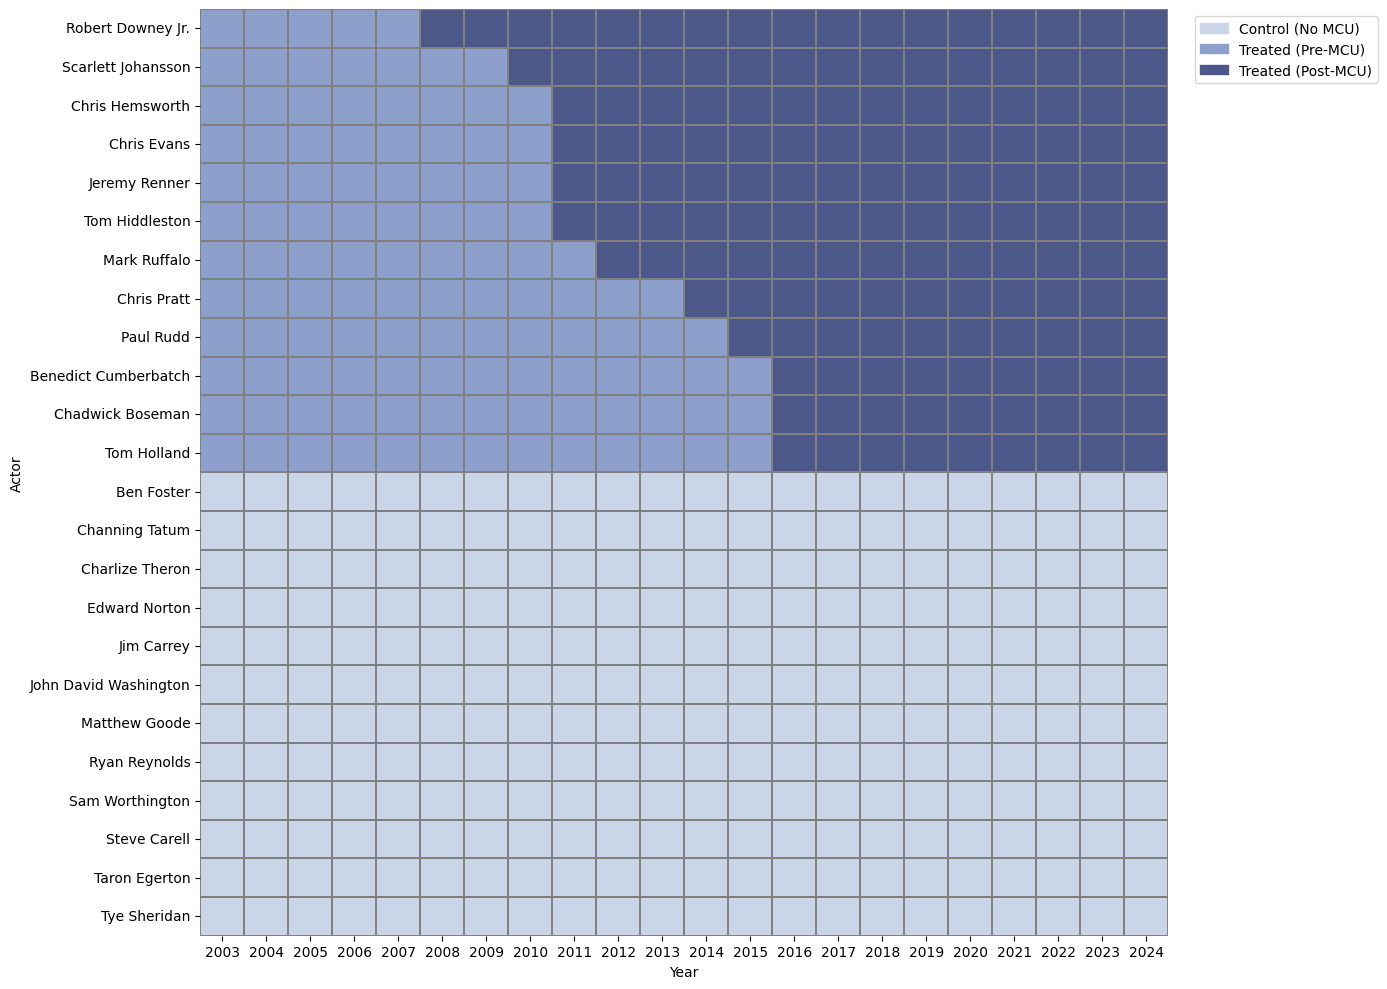

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# --- Step 1: Setup base matrix ---
years = list(range(2003, 2025))
actors = heatmap_df.index.tolist()

# Create full grid: rows = actors, columns = years
status_matrix = pd.DataFrame(index=actors, columns=years)

# --- Step 2: Fill in treatment status ---
for actor in actors:
    entry_year = heatmap_df.loc[actor, 'MCU Entry Year']
    treated = heatmap_df.loc[actor, 'Treatment']

    for year in years:
        if treated == 0:
            status_matrix.loc[actor, year] = 0  # control
        elif year < entry_year:
            status_matrix.loc[actor, year] = 1  # treated (pre)
        else:
            status_matrix.loc[actor, year] = 2  # treated (post)

status_matrix = status_matrix.astype(float)  # convert to numeric for heatmap

# --- Step 3: Sort actors by entry year ---
entry_order = heatmap_df[heatmap_df['Treatment'] == 1].sort_values('MCU Entry Year').index.tolist()
control_order = heatmap_df[heatmap_df['Treatment'] == 0].index.tolist()
status_matrix = status_matrix.loc[entry_order + control_order]

# --- Step 4: Plot heatmap ---
plt.figure(figsize=(14, 10))
cmap = sns.color_palette(["#cbd5e8", "#8da0cb", "#4c578a"])  # light -> dark

sns.heatmap(
    status_matrix,
    cmap=cmap,
    linewidths=0.2,
    linecolor='gray',
    cbar=False
)

plt.xlabel("Year")
plt.ylabel("Actor")

# Legend
legend_patches = [
    mpatches.Patch(color="#cbd5e8", label='Control (No MCU)'),
    mpatches.Patch(color="#8da0cb", label='Treated (Pre-MCU)'),
    mpatches.Patch(color="#4c578a", label='Treated (Post-MCU)')
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
treatment_control.columns

Index(['title', 'budget', 'revenue', 'runtime', 'release_date', 'cast_order',
       'actor_name', 'imdb_votes', 'Internet Movie Database',
       'Rotten Tomatoes', 'Metacritic', 'opening_weekend', 'Action',
       'Adventure', 'Comedy', 'Drama', 'Family', 'Fantasy', 'Horror', 'Music',
       'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western',
       'MCU', 'MCU Entry', 'release_year', 'release_quarter', 'Treatment',
       'Lead Role', 'Supporting Role', 'MCU Entry Year'],
      dtype='object')

# Preliminary Data Analysis

In [ ]:
import plotly.express as px

# ✅ Step 1: Choose the metric
df = treatment_control.copy()
#df = df[df['Treatment']==1]
df['profit'] = df['revenue'] - df['budget']

# ✅ Step 2: Filter data for years and valid entries
df = df[df['release_year'].between(2003, 2024)]
df = df.dropna(subset=['Treatment', 'release_year', 'budget', 'revenue'])

# Optional: limit to lead roles only
# df = df[df['Lead Role'] == 1]

# ✅ Step 3: Aggregate metric per actor per year
agg = df.groupby(['Treatment', 'release_year']).agg({
    'budget': 'mean',
    'revenue': 'mean',
    'opening_weekend': 'mean'
}).reset_index()

# ✅ Step 4: Plot with Plotly
fig = px.line(
    agg,
    x='release_year',
    y='opening_weekend',  # Change to 'budget' or 'revenue' if needed
    color='Treatment',
    markers=True,
    title='Profit per Treatment Group over Time (2003–2024)',
    labels={'release_year': 'Year', 'opening_weekend': 'Opening Weekend Performance'},
    hover_name='Treatment'
)

fig.update_layout(
    xaxis=dict(tickmode='linear', dtick=1),
    hovermode='x unified',
    legend_title='Treatment'
)

fig.show()

In [ ]:
treatment_control['opening_weekend_log'] = np.log(treatment_control["opening_weekend"].clip(lower=1))

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
# 1) TWFE regression
twfe = smf.ols('opening_weekend_log ~ Treatment + C(actor_name) + C(release_year)', data=treatment_control).fit(cov_type='HC1')
print("TWFE treat coef:", twfe.params['Treatment'], "p=", twfe.pvalues['Treatment'])

TWFE treat coef: 1.9147393638815493 p= 0.0035044674802845077


In [ ]:
treatment_control.T

,272,274,1,335,169,250,222,223,176,185,...,71,301,120,208,130,137,308,270,44,12
title,My Life Without Me,View from the Top,The Shape of Things,S.W.A.T.,Lost in Translation,In the Cut,The Singing Detective,Gothika,Girl with a Pearl Earring,The Perfect Score,...,Despicable Me 4,Horizon: An American Saga - Chapter 1,Fly Me to the Moon,Deadpool & Wolverine,Deadpool & Wolverine,Blink Twice,The Killer,The Order,A Complete Unknown,Sonic the Hedgehog 3
budget,2500000,30000000,0,80000000,4000000,12000000,8000000,40000000,10500000,0,...,100000000,50000000,100000000,200000000,200000000,20000000,30000000,20000000,65000000,122000000
revenue,12300000,19526014,735992,207700000,119723856,23726793,337174,141591324,31500000,10900000,...,969280910,38735702,42247783,1338073645,1338073645,46393906,318618,1970445,138003641,486018457
runtime,106,87,96,117,102,119,109,98,101,93,...,94,182,132,128,128,102,126,116,140,110
release_date,2003-03-07 00:00:00,2003-03-21 00:00:00,2003-07-24 00:00:00,2003-08-08 00:00:00,2003-09-18 00:00:00,2003-10-22 00:00:00,2003-10-24 00:00:00,2003-11-21 00:00:00,2003-12-12 00:00:00,2004-01-30 00:00:00,...,2024-06-20 00:00:00,2024-06-26 00:00:00,2024-07-10 00:00:00,2024-07-24 00:00:00,2024-07-24 00:00:00,2024-08-21 00:00:00,2024-08-22 00:00:00,2024-12-05 00:00:00,2024-12-18 00:00:00,2024-12-19 00:00:00
cast_order,3,2,0,5,1,1,0,1,0,2,...,0,2,1,0,11,1,2,2,1,0
actor_name,Mark Ruffalo,Mark Ruffalo,Paul Rudd,Jeremy Renner,Scarlett Johansson,Mark Ruffalo,Robert Downey Jr.,Robert Downey Jr.,Scarlett Johansson,Scarlett Johansson,...,Steve Carell,Sam Worthington,Channing Tatum,Ryan Reynolds,Channing Tatum,Channing Tatum,Sam Worthington,Tye Sheridan,Edward Norton,Jim Carrey
imdb_votes,"26,182","29,610","11,962","156,467","507,784","26,960","9,026","120,906","83,988","26,497",...,"66,039","39,859","49,528","1,204,874","1,204,874","106,257","207,922","44,107","74,164","60,288"
Internet Movie Database,7.4,5.3,6.6,6.1,7.7,5.4,5.4,5.8,6.9,5.7,...,6.2,6.7,6.6,8.0,8.0,6.5,6.7,6.8,7.7,6.9
Rotten Tomatoes,NaN,14.0,64.0,48.0,95.0,35.0,39.0,15.0,73.0,15.0,...,56.0,51.0,65.0,85.0,85.0,75.0,85.0,92.0,82.0,85.0


In [ ]:
model2 = treatment_control.groupby(["actor_name","release_year"]).agg(count_lead_roles=("Lead Role","sum"),
                                                                      average_rating=("Internet Movie Database","mean"),
                                                                      film_count=("actor_name","count"),
                                                                      opening_weekend_log=("opening_weekend_log","mean"),
                                                                      Treatment=("Treatment","first")).reset_index()
model2.dropna(axis=0,inplace=True)

In [ ]:
model2.head()

,actor_name,release_year,count_lead_roles,average_rating,film_count,opening_weekend_log,Treatment
0,Ben Foster,2003,0,6.65,2,13.775725,0
2,Ben Foster,2005,1,6.50,1,16.097893,0
3,Ben Foster,2006,0,6.75,2,17.060809,0
4,Ben Foster,2007,0,7.10,2,16.521078,0
6,Ben Foster,2009,2,6.90,2,13.003172,0


# Exploratory Data Analysis

<ipython-input-224-a3a6793fb099>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



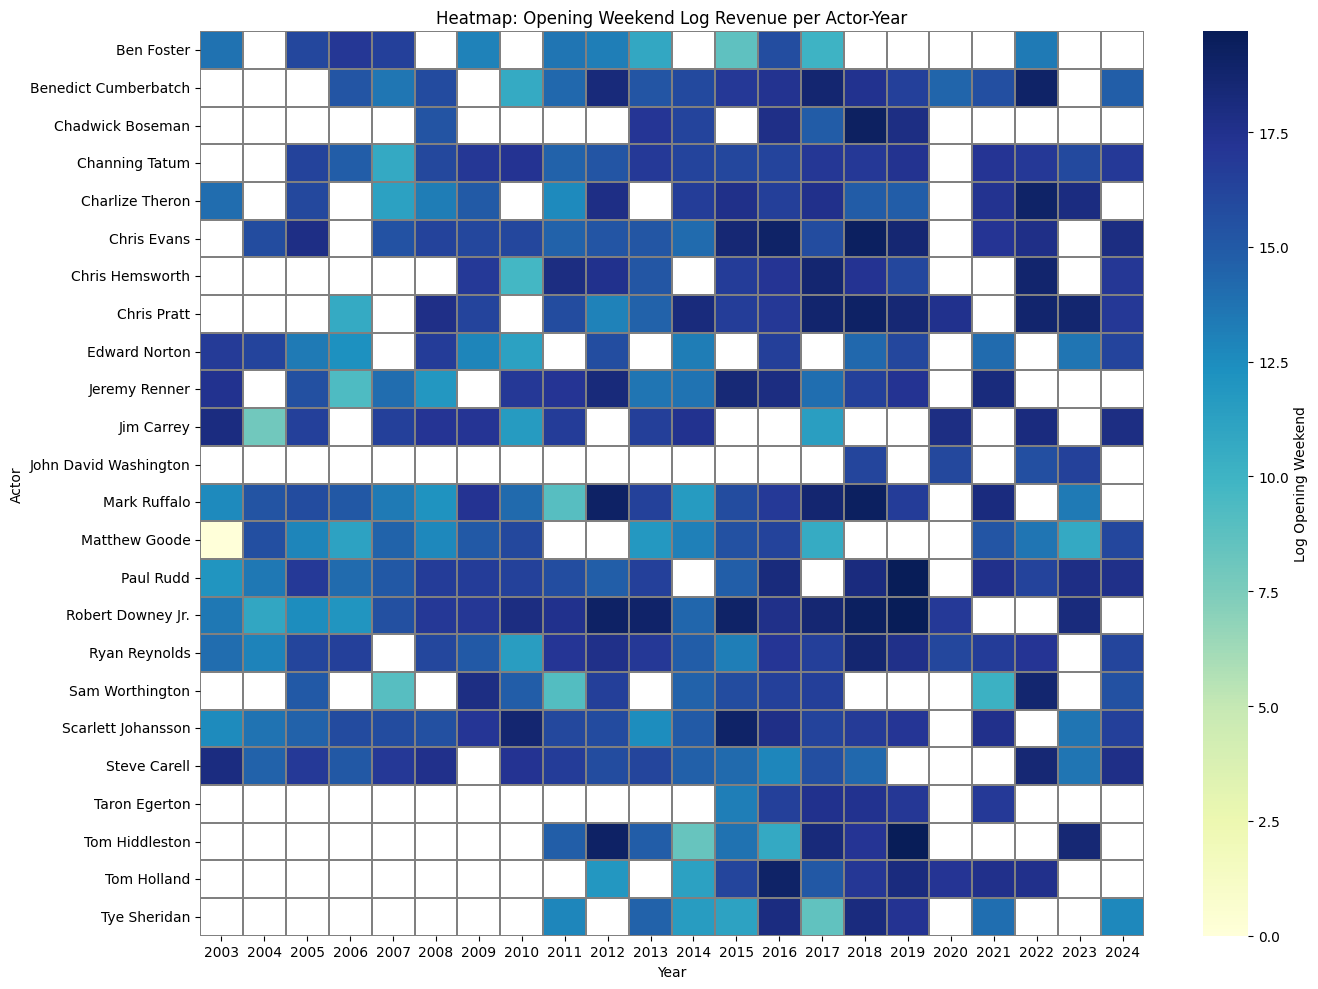

In [ ]:
df_event = df_event[df_event['Treatment'] == 1]  # only treated actors
df_event['event_time'] = df_event['release_year'] - df_event['MCU Entry Year']
df_event = df_event[df_event['event_time'].between(-5, 10)]

# Group: average outcome by event time
agg = df_event.groupby('event_time')['opening_weekend_log'].mean().reset_index()

pivot = treatment_control.pivot_table(
    index='actor_name',
    columns='release_year',
    values='opening_weekend_log',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.1, linecolor='gray', cbar_kws={'label': 'Log Opening Weekend'})
plt.title("Heatmap: Opening Weekend Log Revenue per Actor-Year")
plt.xlabel("Year")
plt.ylabel("Actor")
plt.tight_layout()
plt.show()

In [ ]:
treatment_control.reset_index(drop=True).to_json("treatment_control.json",orient="columns")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset (adjust path if needed)
df = pd.read_json("treatment_control.json")

In [ ]:
# Convert key numeric columns
df['opening_weekend_log'] = pd.to_numeric(df.get('opening_weekend_log'), errors='coerce')
df['budget'] = pd.to_numeric(df.get('budget'), errors='coerce')
df['revenue'] = pd.to_numeric(df.get('revenue'), errors='coerce')
df['runtime'] = pd.to_numeric(df.get('runtime'), errors='coerce')
df['imdb_votes'] = pd.to_numeric(df.get('imdb_votes'), errors='coerce')
df['release_year'] = pd.to_numeric(df.get('release_year'), errors='coerce')

# Set seaborn style
sns.set(style="whitegrid")

In [ ]:
numeric_cols = ['opening_weekend_log', 'budget', 'revenue', 'runtime', 'imdb_votes']

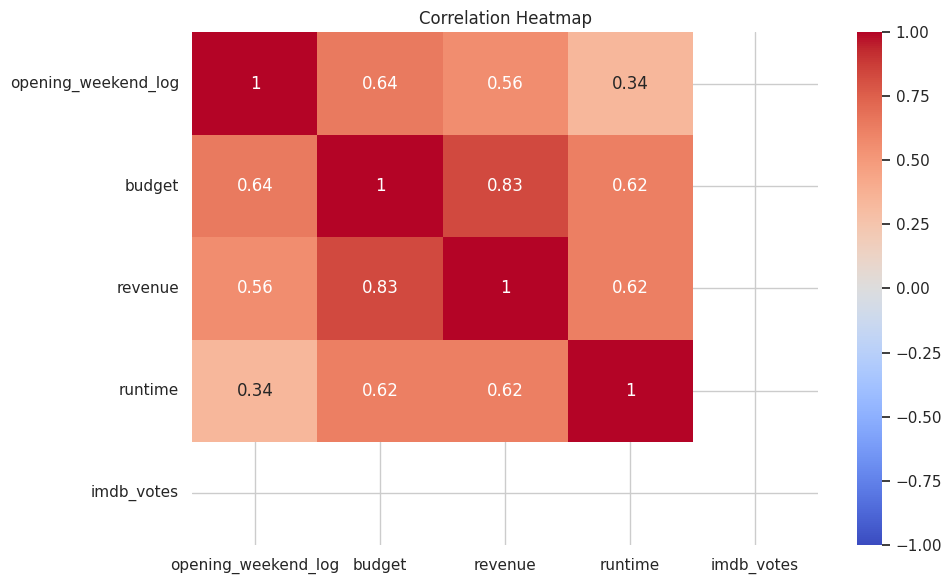

In [ ]:
# 2. Correlation Heatmap
plt.figure(figsize=(10, 6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

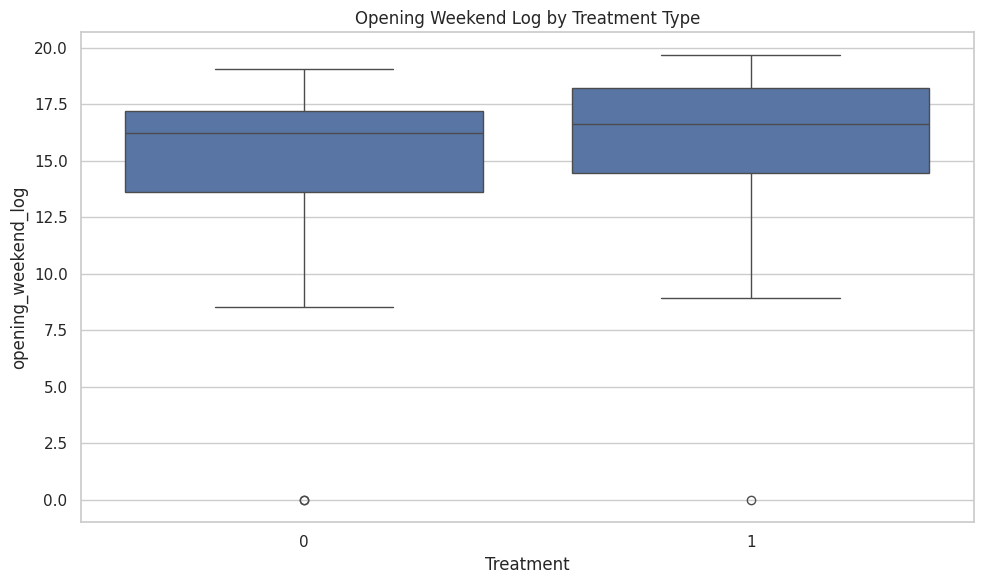

In [ ]:
# 3. Boxplot: Treatment vs Opening Weekend
plt.figure(figsize=(10, 6))
sns.boxplot(x='Treatment', y='opening_weekend_log', data=df)
plt.title("Opening Weekend Log by Treatment Type")
plt.tight_layout()
plt.show()

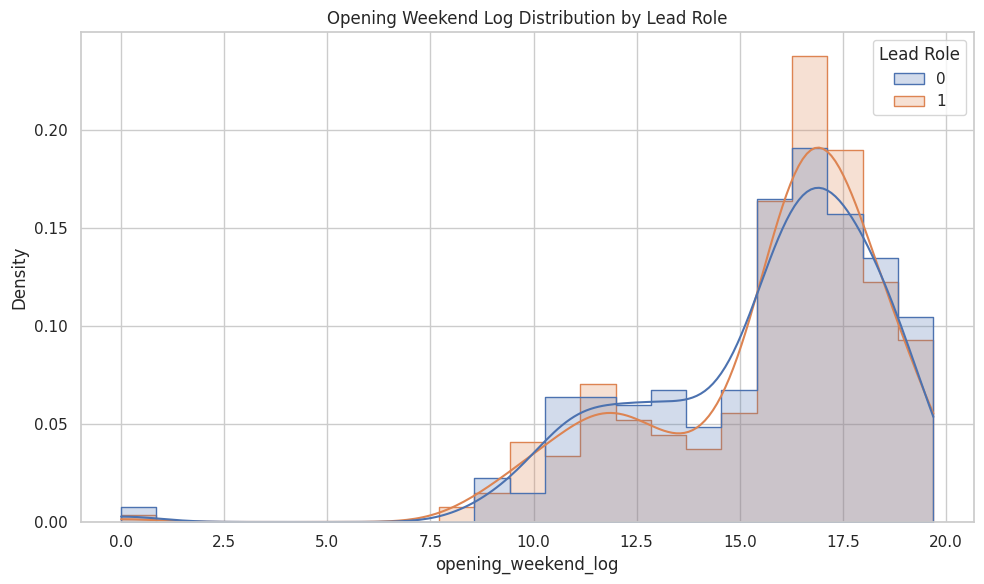

In [ ]:
# 4. Distribution: Lead Role
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='opening_weekend_log', hue='Lead Role', kde=True, element="step", stat="density", common_norm=False)
plt.title("Opening Weekend Log Distribution by Lead Role")
plt.tight_layout()
plt.show()

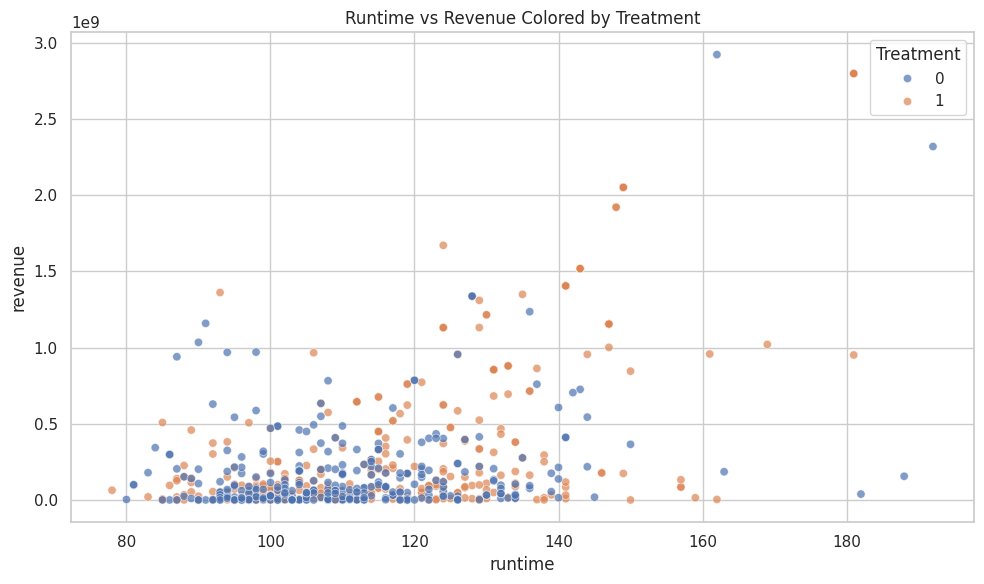

In [ ]:
a# 5. Scatterplot: Runtime vs Revenue by Treatment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='runtime', y='revenue', hue='Treatment', alpha=0.7)
plt.title("Runtime vs Revenue Colored by Treatment")
plt.tight_layout()
plt.show()

<ipython-input-248-318f76580552>:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




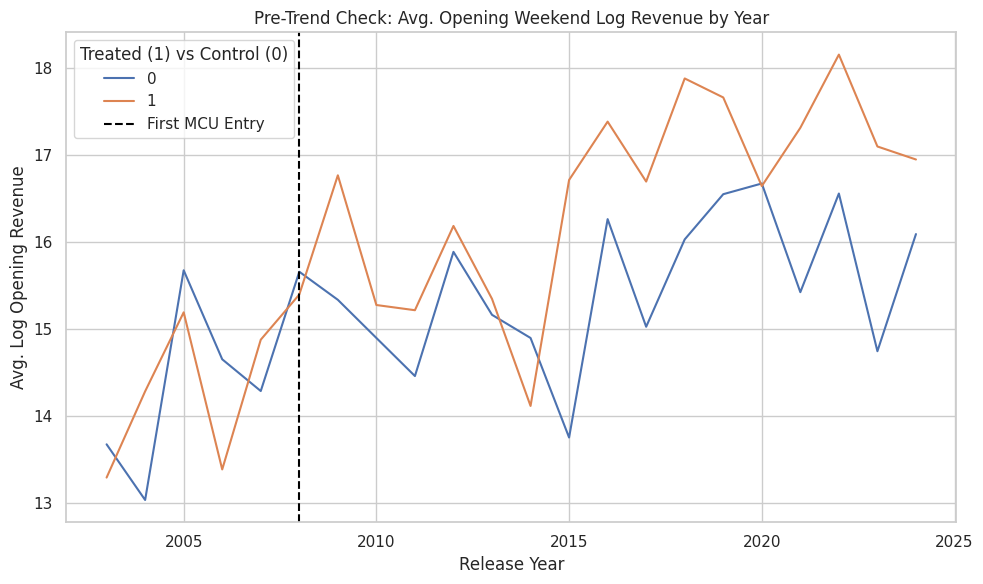

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='release_year', y='opening_weekend_log', hue='Treatment', estimator='mean', ci=None)
plt.title("Pre-Trend Check: Avg. Opening Weekend Log Revenue by Year")
plt.axvline(x=2008, color='black', linestyle='--', label="First MCU Entry")
plt.xlabel("Release Year")
plt.ylabel("Avg. Log Opening Revenue")
plt.legend(title="Treated (1) vs Control (0)")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-250-41f3763148ea>:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




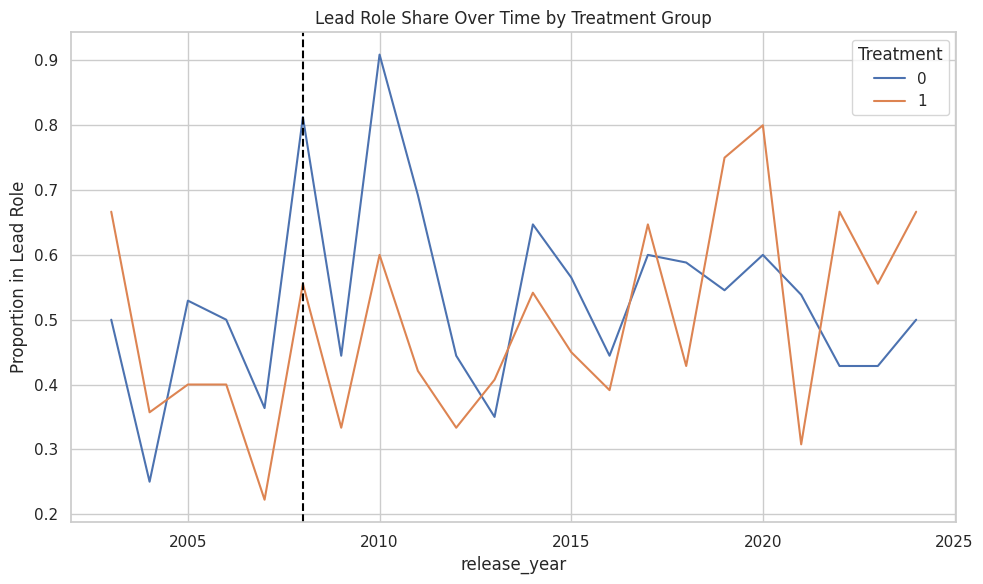

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='release_year',
    y='Lead Role',
    hue='Treatment',
    estimator='mean',
    ci=None
)
plt.axvline(x=2008, color='black', linestyle='--', label="First MCU Entry")
plt.title("Lead Role Share Over Time by Treatment Group")
plt.ylabel("Proportion in Lead Role")
plt.grid(True)
plt.tight_layout()
plt.show()

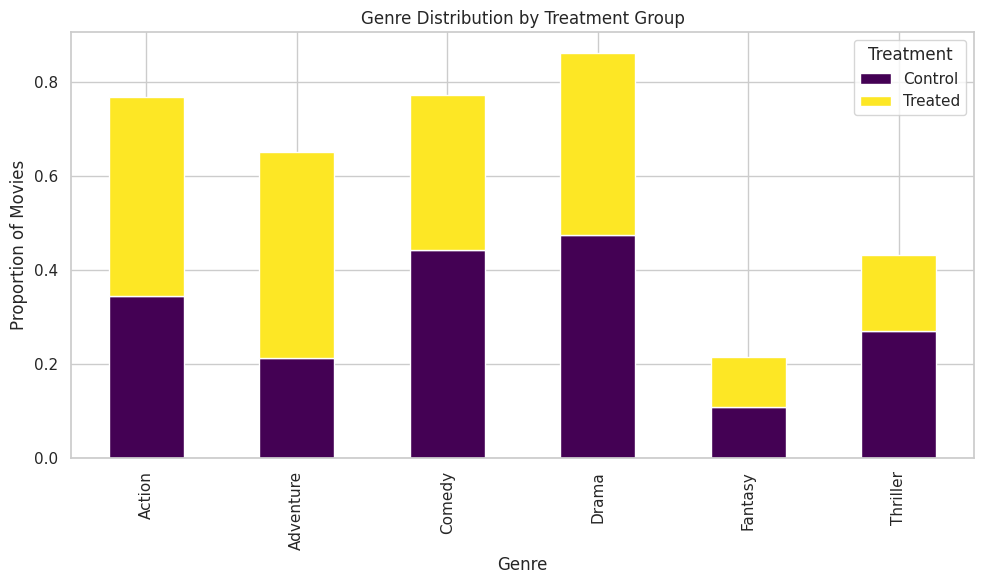

In [ ]:
genre_cols = ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Thriller']
genre_share = df.groupby('Treatment')[genre_cols].mean().T

genre_share.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("Genre Distribution by Treatment Group")
plt.ylabel("Proportion of Movies")
plt.xlabel("Genre")
plt.legend(title="Treatment", labels=['Control', 'Treated'])
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm

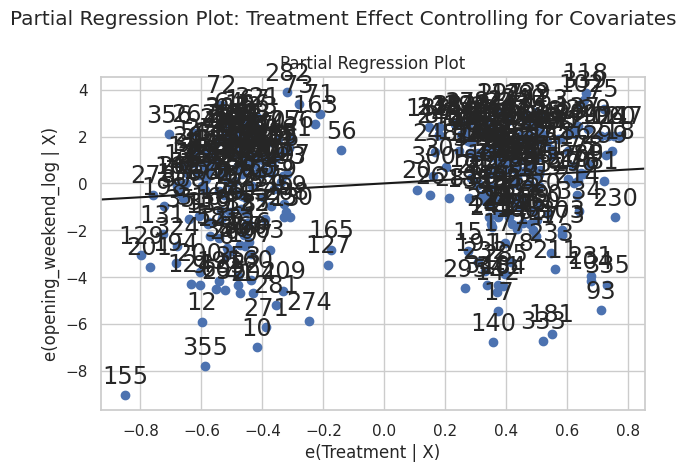

In [ ]:
# Run OLS model with relevant controls
model = smf.ols(
    formula='opening_weekend_log ~ Treatment + average_rating + film_count + count_lead_roles + C(actor_name) + C(release_year)',
    data=model2
).fit()

# Plot partial regression (added variable plot)
fig = sm.graphics.plot_partregress('opening_weekend_log', 'Treatment', ['average_rating', 'film_count', 'count_lead_roles'], data=model2)
fig.suptitle("Partial Regression Plot: Treatment Effect Controlling for Covariates")
plt.tight_layout()
plt.show()

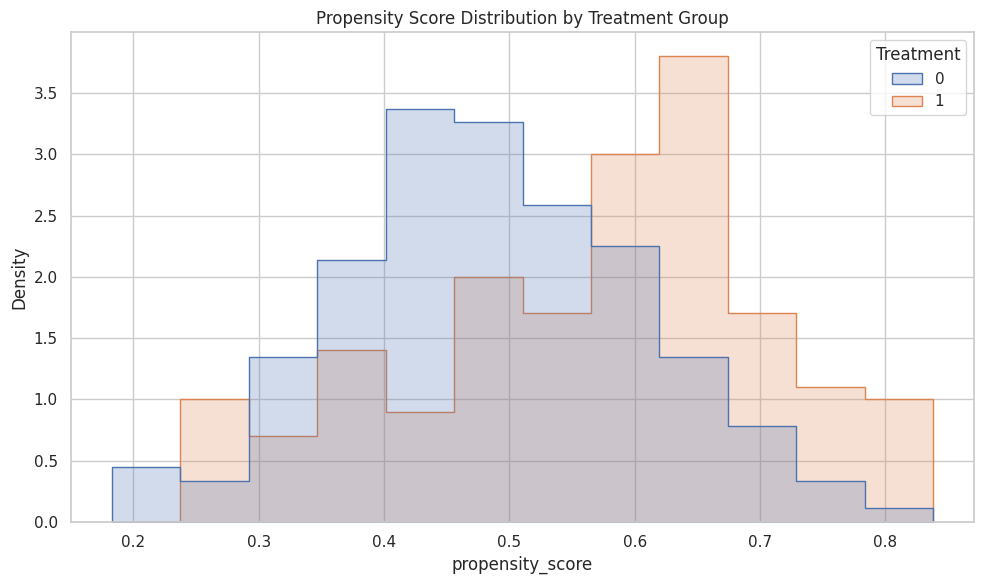

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define feature set for matching
X = model2[['average_rating', 'film_count', 'count_lead_roles']].dropna()
y = model2.loc[X.index, 'Treatment']

# Fit logistic model
ps_model = LogisticRegression()
ps_model.fit(X, y)
model2.loc[X.index, 'propensity_score'] = ps_model.predict_proba(X)[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=model2, x='propensity_score', hue='Treatment', element='step', stat='density', common_norm=False)
plt.title("Propensity Score Distribution by Treatment Group")
plt.tight_layout()
plt.show()

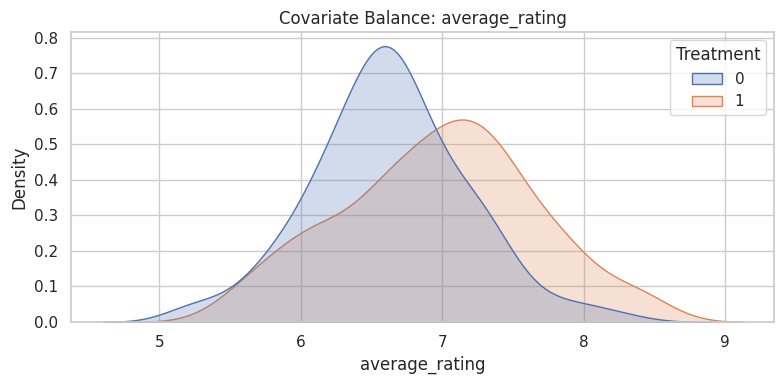

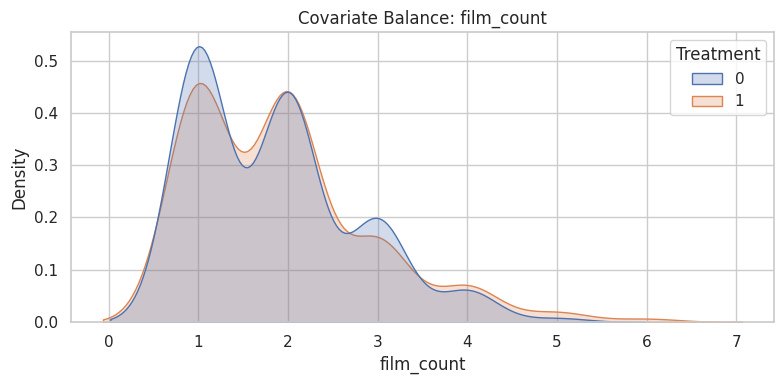

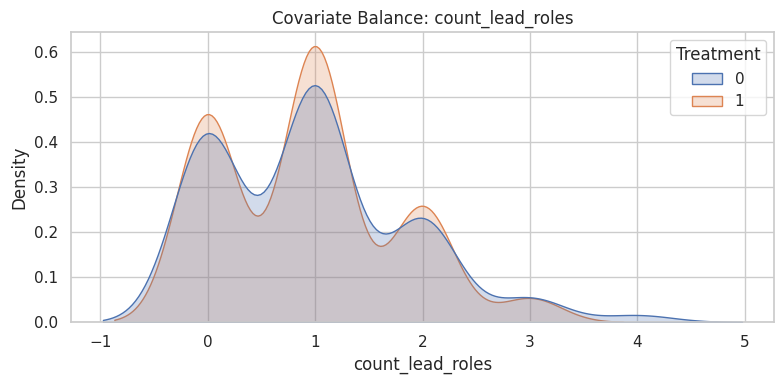

In [ ]:
# Visualize distribution of covariates
for var in ['average_rating', 'film_count', 'count_lead_roles']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=model2, x=var, hue='Treatment', fill=True, common_norm=False)
    plt.title(f"Covariate Balance: {var}")
    plt.tight_layout()
    plt.show()

# Weighted SMF model

In [ ]:
# Add inverse probability weights (IPW)
model2['ipw'] = np.where(
    model2['Treatment'] == 1,
    1 / model2['propensity_score'],
    1 / (1 - model2['propensity_score'])
)

# Weighted regression
weighted_model = smf.wls(
    formula='opening_weekend_log ~ Treatment',
    data=model2,
    weights=model2['ipw']
).fit()

print(weighted_model.summary())

                             WLS Regression Results                            
Dep. Variable:     opening_weekend_log   R-squared:                       0.031
Model:                             WLS   Adj. R-squared:                  0.028
Method:                  Least Squares   F-statistic:                     10.86
Date:                 Wed, 07 May 2025   Prob (F-statistic):            0.00108
Time:                         18:00:04   Log-Likelihood:                -799.81
No. Observations:                  346   AIC:                             1604.
Df Residuals:                      344   BIC:                             1611.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.1462      0.184     82.36

# Difference-in-Differences (DiD) Model Estimation

In [ ]:
# 3. Estimate the DiD with controls + fixed effects
formula = (
    'opening_weekend_log ~ Treatment'
    ' + film_count + average_rating + count_lead_roles'
    ' + C(actor_name) + C(release_year)'
)

did_model = smf.ols(formula, data=model2) \
               .fit(cov_type='cluster', cov_kwds={'groups': model2['actor_name']})

print(did_model.summary())

                             OLS Regression Results                            
Dep. Variable:     opening_weekend_log   R-squared:                       0.352
Model:                             OLS   Adj. R-squared:                  0.250
Method:                  Least Squares   F-statistic:                     107.0
Date:                 Wed, 07 May 2025   Prob (F-statistic):           2.60e-18
Time:                         18:05:40   Log-Likelihood:                -718.59
No. Observations:                  346   AIC:                             1533.
Df Residuals:                      298   BIC:                             1718.
Df Model:                           47                                         
Covariance Type:               cluster                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 48, but rank is 23



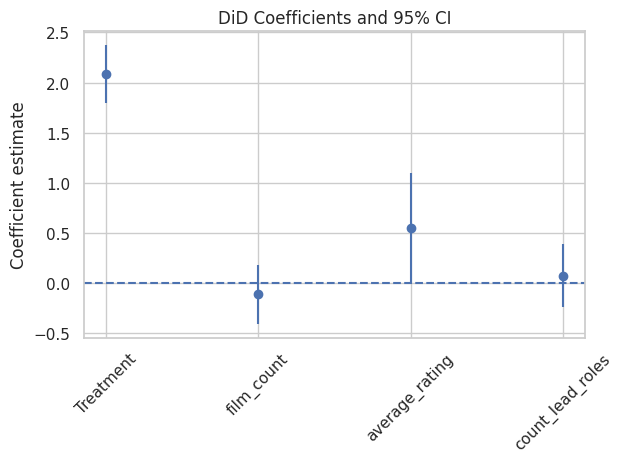

In [ ]:
# 3. Pull out the four key coefficients + CIs
vars_to_plot = ['Treatment','film_count','average_rating','count_lead_roles']  # or your exact names
params = did_model.params[vars_to_plot]
ci_low, ci_high = did_model.conf_int().loc[vars_to_plot].T.values

# 4. Draw the coefficient plot
plt.figure()
plt.errorbar(
    vars_to_plot,
    params.values,
    yerr=[params.values - ci_low, ci_high - params.values],
    fmt='o'
)
plt.axhline(0, linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Coefficient estimate')
plt.title('DiD Coefficients and 95% CI')
plt.tight_layout()
plt.show()

In [ ]:
df_event = treatment_control.copy()